# Evaluación

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, MaxPooling2D, Input, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from glob import glob
import numpy as np
from numpy.linalg import inv
import os
import shutil
import random
import cv2
import gc
import matplotlib.pyplot as plt
from itertools import zip_longest
import uuid
from multiprocessing import Pool, cpu_count

%matplotlib inline

Using TensorFlow backend.


## Construcción del dataset

Armamos un dataset para evaluar los resultados de los modelos contra *baselines*. Vamos a usar las 5k imágenes del dataset de validación de COCO 2017, y generar los pares de parches transformados para cada imagen del dataset original, tal como está especificado en el paper:

> To create this test set, we randomly chose $5000$ images from the test set and resized each image to grayscale $640 \times 480$, and generate a pairs of image patches sized $256 \times 256$ and corresponding ground truth homography, using the approach described in Figure 3 with $\rho = 64$

In [4]:
#DATA_DIR = os.path.join('e:', 'Facultad', 'vc')
DATA_DIR = os.path.join('./')

In [5]:
X_test_files = glob(os.path.join(DATA_DIR, 'val2017', '*.jpg'))

In [6]:
len(X_test_files), X_test_files[0]

(5000, './val2017/000000099039.jpg')

Definimos los parámetros del dataset de test

In [7]:
WIDTH, HEIGHT = 640, 480
RHO = 64
PATCH_SIZE = 256

Usamos el mismo código que en el notebook de Modelo:

In [8]:
def random_patch_positions():
    """Calculate random position for patch P"""
    px = random.randint(RHO, WIDTH - PATCH_SIZE - RHO)
    py = random.randint(RHO, HEIGHT - PATCH_SIZE - RHO)
    return px, py  

def random_delta():
    """Calculate random delta for patch corner distortion"""
    return np.random.randint(-RHO, RHO, size=2)

def extract_from_patch(img, patch):
    """Extract patch from image"""
    a, _, c, _ = patch
    return img[a[1]:c[1], a[0]:c[0]]

def build_random_patch():
    px, py = random_patch_positions()
    return [(px, py),
            (px + PATCH_SIZE, py),
            (px + PATCH_SIZE, py + PATCH_SIZE),
            (px, py + PATCH_SIZE)]

def distort_patch(patch):
    return [p + random_delta() for p in patch]


def warp_image(img, patch, new_patch):
    # Get homography matrix
    H = cv2.getPerspectiveTransform(
        np.float32(patch),
        np.float32(new_patch))
    
    # Transform image with H
    return cv2.warpPerspective(img, inv(H),
        (img.shape[1], img.shape[0]))  

def process_image(img, debug=False):
    # Resize and convert to grayscale
    resized_img = cv2.resize(img, (WIDTH, HEIGHT))
    if len(resized_img.shape) == 3:
        gray_img = cv2.cvtColor(resized_img, cv2.COLOR_RGB2GRAY)
    else:
        gray_img = resized_img
        
    assert(len(gray_img.shape) == 2)
 
    # Build patch, and perturb corners
    patch = build_random_patch()
    distorted_patch = distort_patch(patch)

    warped_img = warp_image(gray_img, patch, distorted_patch)
    
    # Extract patches
    a_img = extract_from_patch(gray_img, patch)
    b_img = extract_from_patch(warped_img, patch)
    
    # Stack patch images together
    x = np.dstack([a_img, b_img])
    
    # Subtract patches to get delta
    # int8 is good enough because RHO = 32, so, values are in [-32, 32] range
    y = np.subtract(patch, distorted_patch).ravel().astype(np.int8)

    if debug:
        # On debug mode, return also original patch and warped img for plotting
        return x, y, (patch, distorted_patch), (gray_img, warped_img)
    
    return x, y

In [9]:
def plot_processed_image(img_path):
    img = plt.imread(img_path)
    x, y, patches, imgs = process_image(img, debug=True)
    
    print('Label: {}'.format(y))
    
    for i in range(2):
        plt.subplot(2, 2, i+1)
        plt.grid(False)    
        temp_img = cv2.cvtColor(imgs[i], cv2.COLOR_GRAY2RGB)
        cv2.polylines(temp_img, np.int32([patches[i]]), 1, (255, 0, 0), thickness=2)    
        plt.imshow(temp_img, cmap='gray')

    for i in range(2):
        patch_img = x[:, :, i]
        
        print('[{}] shape={}'.format(i, patch_img.shape))        
        print('[{}] mean={}, std={}'.format(
            i, np.mean(patch_img), np.std(patch_img)))
      
        plt.subplot(2, 2, i+3)
        plt.grid(False)
        plt.imshow(patch_img, cmap='gray')
        #plt.text(0.5,0.5, str((2, 2, i)), ha=’center’, fontsize = 10)
        plt.tight_layout()

Label: [-25  42 -53 -30  24   6   0  32]
[0] shape=(256, 256)
[0] mean=166.53392028808594, std=54.45142637056495
[1] shape=(256, 256)
[1] mean=167.2158203125, std=54.53544030471773


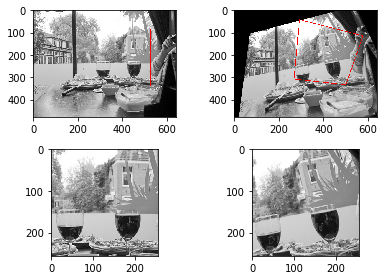

In [10]:
plot_processed_image(X_test_files[0])

In [11]:
def generate_test_dataset(X, out_dir):
    random.shuffle(X)
    
    xs, ys = [], []
    for img_path in X:
        img = plt.imread(img_path)
        try:
            x, y = process_image(img)
        except:
            print("Image broken? {}".format(img_path))
            raise
        xs.append(x)
        ys.append(y)

    xs = np.array(xs, dtype=np.uint8)
    ys = np.array(ys, dtype=np.int8)

    outfile = os.path.join(out_dir, '{}.npz'.format(uuid.uuid4()))
    os.makedirs(os.path.dirname(outfile), exist_ok=True)
    np.savez_compressed(outfile, x=xs, y=ys)
    print(outfile)
    return outfile

In [15]:
test_path = generate_test_dataset(X_test_files, os.path.join(DATA_DIR, 'test_dataset'))

./test_dataset/d9be154b-96f8-4e8d-a2dc-356c7c38b6fc.npz


In [12]:
test_path = glob(os.path.join(DATA_DIR, 'test_dataset', '*.npz'))[0]

In [13]:
dataset = np.load(test_path)
X_test, y_test = dataset['x'], dataset['y']

In [14]:
X_test.shape, y_test.shape

((5000, 256, 256, 2), (5000, 8))

## Métrica

Utilizamos la métrica *Mean average corner error* (MACE), que mide en promedio la diferencia en píxeles de cada esquina:

> We report the Mean Average Corner Error for each approach. To measure this metric, one first computes the L2 distance between the ground truth corner position and the estimated corner position. The error is averaged over the four corners of the image, and the mean is computed over the entire test set.

In [15]:
# Para probar, tomamos las primeras 3 etiquetas de y_test
y_true = y_test[:3]

# En el caso de la identidad, el y de predicción sería el vector nulo (deltas = 0)
y_pred = np.zeros((y_true.shape[0], 8), dtype=np.int8)

In [16]:
y_true

array([[-22,  13,  13,  14, -37,   9, -16,  -3],
       [-47,  18,  54,  25,  -7, -48,  19, -22],
       [-58,  46,  41,  -1, -11,  14,   5,   0]], dtype=int8)

In [17]:
y_pred

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]], dtype=int8)

In [18]:
diff = (y_true.reshape(-1, 4, 2) - y_pred.reshape(-1, 4, 2)).astype(np.int)
diff[0, :, :]

array([[-22,  13],
       [ 13,  14],
       [-37,   9],
       [-16,  -3]])

In [19]:
squared_diff = np.square(diff)
squared_diff[0, :, :]

array([[ 484,  169],
       [ 169,  196],
       [1369,   81],
       [ 256,    9]])

In [20]:
squared_diff_sum = np.sum(squared_diff, axis=2)
squared_diff_sum[0]

array([ 653,  365, 1450,  265])

In [21]:
diff_sum_abs = np.sqrt(squared_diff_sum)
diff_sum_abs[0]

array([25.55386468, 19.10497317, 38.07886553, 16.2788206 ])

In [22]:
np.mean(diff_sum_abs)

35.35600571342713

In [23]:
def mean_average_corner_error(y_true, y_pred):
    diff = (y_true.reshape(-1, 4, 2) - y_pred.reshape(-1, 4, 2)).astype(np.int)
    return np.mean(np.sqrt(np.sum(np.square(diff), axis=2)))

In [24]:
mean_average_corner_error(y_true, y_pred)

35.35600571342713

## Evaluar con identidad

Un baseline utilizado en el paper es asumir que el $H = I$. En términos de la salida de la red (la etiqueta del dataset), el delta de los 4 puntos sería 0, dado que la homografía que es identidad implica que no hay transformación y por lo tanto las esquinas del parche no fueron modificadas.

In [25]:
y_pred = np.zeros((y_test.shape[0], 8))
y_pred.shape

(5000, 8)

In [26]:
mean_average_corner_error(y_test, y_pred)

48.85344330518615

Vemos que coincide bastante con los resultados reportados.

## Evaluar con ORB + RANSAC

El segundo *baseline* propuesto por el paper es utilizar un método tradicional como ORB + RANSAC para estimar la homografía:

> We use the default OpenCV parameters in the traditional homography estimator. This estimates ORB features at multiple scales and uses the top 25 scoring matches as input to the RANSAC estimator. In scenarios where too few ORB features are computed, the ORB+RANSAC approach outputs an identity estimate. In scenarios where the ORB+RANSAC’s estimate is too extreme, the 4-point homography estimate is clipped at $[-64,64]$.

In [27]:
img1 = X_test[2, :, :, 0]
img2 = X_test[2, :, :, 1]

# Initiate STAR detector
orb = cv2.ORB_create()

# find the keypoints and compute the descriptors with ORB
kp1, desc1 = orb.detectAndCompute(img1, None)
kp2, desc2 = orb.detectAndCompute(img2, None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(desc1, desc2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

print('Found {} matches'.format(len(matches)))

Found 197 matches


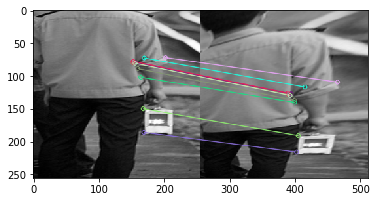

In [28]:
# draw first 10 matches...
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:10], None, flags=2)

plt.imshow(img3)

In [29]:
MIN_MATCH_COUNT = 25

In [30]:
if len(matches) >= MIN_MATCH_COUNT:
    matches = matches[:MIN_MATCH_COUNT]
    
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()
else:
    print("Not enough matches are found - {}/{} - using identity".format(len(matches), MIN_MATCH_COUNT))
    H = np.eye(3)
    matchesMask = None

In [31]:
H

array([[ 1.04133843e+00,  2.33642255e-01, -5.38572113e+01],
       [-3.79298222e-01,  1.23712633e+00,  7.79838549e+01],
       [-1.60144274e-03,  2.12065905e-03,  1.00000000e+00]])

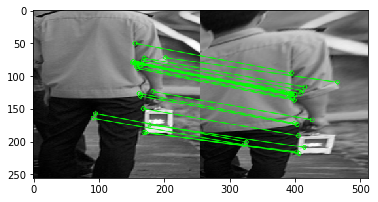

(<matplotlib.image.AxesImage at 0x7f6506fb8ac8>, None)

In [32]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches,None,**draw_params)

plt.imshow(img3, 'gray'),plt.show()

In [33]:
h, w = img1.shape
x1 = np.array([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]], dtype=np.float32)

dst = cv2.perspectiveTransform(x1.reshape(-1,1,2), H)
x2 = dst[:, 0, :]

In [34]:
x1

array([[  0.,   0.],
       [  0., 255.],
       [255., 255.],
       [255.,   0.]], dtype=float32)

In [35]:
x2

array([[-53.857212 ,  77.98386  ],
       [  3.7134492, 255.36035  ],
       [239.54683  , 262.03638  ],
       [357.7968   , -31.670343 ]], dtype=float32)

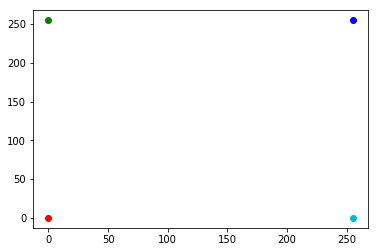

In [41]:
plt.plot(x1[0, 0], x1[0, 1], 'ro')
plt.plot(x1[1, 0], x1[1, 1], 'go')
plt.plot(x1[2, 0], x1[2, 1], 'bo')
plt.plot(x1[3, 0], x1[3, 1], 'co')

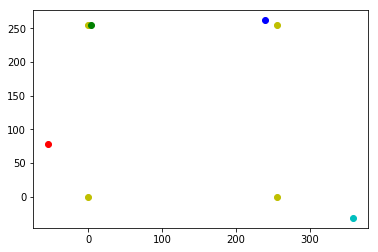

In [42]:
plt.plot(x1[:, 0], x1[:, 1], 'yo')

plt.plot(x2[0, 0], x2[0, 1], 'ro')
plt.plot(x2[1, 0], x2[1, 1], 'go')
plt.plot(x2[2, 0], x2[2, 1], 'bo')
plt.plot(x2[3, 0], x2[3, 1], 'co')

In [43]:
diff = x1 - x2
diff

array([[  53.857212  ,  -77.98386   ],
       [  -3.7134492 ,   -0.36035156],
       [  15.453171  ,   -7.036377  ],
       [-102.796814  ,   31.670343  ]], dtype=float32)

In [44]:
scaled_diff = diff / np.max(np.abs(diff))
scaled_diff

array([[ 0.5239191 , -0.75862134],
       [-0.03612417, -0.00350547],
       [ 0.15032732, -0.06844937],
       [-1.        ,  0.3080868 ]], dtype=float32)

In [45]:
diff_test = y_test[2].reshape(4,2)
scaled_diff_test = diff_test / np.max(np.abs(diff_test))
scaled_diff_test

array([[-1.        ,  0.79310345],
       [ 0.70689655, -0.01724138],
       [-0.18965517,  0.24137931],
       [ 0.0862069 ,  0.        ]])

In [46]:
base = np.array([[0, 0], [0, 1], [1, 1], [1, 0]])
res_pred = np.clip((base - scaled_diff) * RHO, -RHO, RHO)
res_test = (base - scaled_diff_test) * RHO

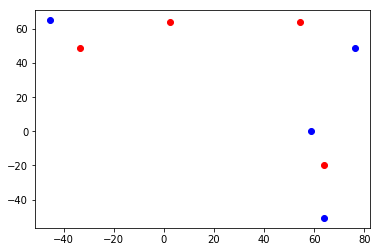

In [47]:
plt.plot(res_test[:, 0], res_test[:, 1], 'bo')
plt.plot(res_pred[:, 0], res_pred[:, 1], 'ro')

Graficamos los puntos originales y los estimados por ORB + `findHomography`:

In [48]:
def plot_patches(img1, img2, p1, p2):
    img1 = img1.copy()
    img2 = img2.copy()
    if len(img1.shape) == 2:
        img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2RGB)
    if len(img2.shape) == 2:
        img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2RGB)

    cv2.polylines(img1, np.int32([p1]), 1, (255, 0, 0), thickness=2)
    cv2.polylines(img2, np.int32([p2]), 1, (255, 0, 0), thickness=2)    
    plt.imshow(np.concatenate([img1, img2], axis=1))

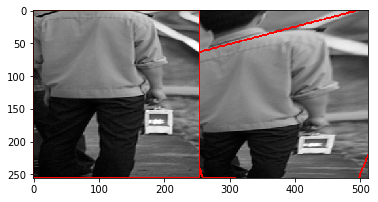

In [49]:
plot_patches(img1, img2, x1, x2)

### Construimos modelo ORB+RANSAC

In [55]:
class ORBEstimator:
    def __init__(self, min_match_count=25):
        self.orb = cv2.ORB_create()
        self.min_match_count = min_match_count

    def predict(self, X):
        return np.array([self._predict_image(x) for x in X])
        
    def _predict_image(self, x):
        img1 = x[:, :, 0]
        img2 = x[:, :, 1]
        
        matches, keypoints = self._get_matches(img1, img2)
        if not matches or not keypoints:
            return np.zeros(8)
        
        H = self._find_homography(matches, keypoints)
        
        h, w = img1.shape
        x1 = np.array([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]], dtype=np.float32) 

        dst = cv2.perspectiveTransform(x1.reshape(-1,1,2), H)
        x2 = dst[:, 0, :].astype(np.float32)
        
        diff = x1 - x2
        res = np.clip(diff, -RHO, RHO)
        
        return np.round(res).reshape(-1)
    
    def _get_matches(self, img1, img2):
        # find the keypoints and compute the descriptors with ORB
        kp1, desc1 = self.orb.detectAndCompute(img1, None)
        kp2, desc2 = self.orb.detectAndCompute(img2, None)
        
        # if no keypoints found, return empty list
        if not kp1 or not kp2:
            return [], []

        # create BFMatcher object
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

        # Match descriptors.
        matches = bf.match(desc1, desc2)

        # Sort them in the order of their distance.
        return sorted(matches, key=lambda x: x.distance), (kp1, kp2)
    
    def _find_homography(self, matches, keypoints):
        kp1, kp2 = keypoints
        if len(matches) >= self.min_match_count:
            matches = matches[:self.min_match_count]
            src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
            dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
            H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        else:
            # Not enough matches are found, use identity
            H = np.eye(3)
        return H

In [56]:
orb = ORBEstimator()
y_pred = orb.predict(X_test)

In [57]:
mean_average_corner_error(y_test, y_pred)

80.99642572228879

In [58]:
y_pred[:5]

array([[ 23., -15.,  12.,   4.,  37.,  -6., -14., -15.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [ 54., -64.,  -4.,  -0.,  15.,  -7., -64.,  32.],
       [ 11.,  53.,  24.,  64., -35., -64.,  23., -37.],
       [  7.,  34., -21.,   9.,  -8.,  -7., -10., -56.]])

In [59]:
y_test[:5]

array([[-22,  13,  13,  14, -37,   9, -16,  -3],
       [-47,  18,  54,  25,  -7, -48,  19, -22],
       [-58,  46,  41,  -1, -11,  14,   5,   0],
       [-12, -61, -28,  53,  18,  45, -20, -56],
       [ -2, -27,  15,  55,  10,   7,  19, -12]], dtype=int8)

Esto da muy mal...